# IRRIGA Water Condensation Model
Written by Michael Jenson, [mike@majenson.com.](mailto:mike@majenson.com)

## Table of Contents
1. [Overview](#overview)
2. [Assumptions](#assumptions)
3. [Setup](#setup)
  1. [Python Imports](#python-imports)
  2. [Panel Calculations](#panel-calculations)
  3. [Constant Definitions](#constant-definitions)
  4. [Model Inputs](#model-inputs)
4. [Calculations](#calculations)
5. [Results](#results)
  1. [Transient Temperature Timeline](#transient-temperature-timeline)
  2. [Steady-State Temperature](#steady-state-temperature)
  3. [Steady-State Water Production](#steady-state-water-production)

<a name="overview"></a>
## Overview
This model is intended to provide the amount of water which a passive water condenser could produce in a night.  There are two parts to the model: an initial transient model which calculates how quickly the system can reach its target water production temperature, a steady-state model which calculates the expected long-term temperature, and a steady-state model which calculates the rate of water production.  The steady-state model is only valid if the transient model reaches the dew point temperature during simulation time, the steady-state temperature model is at or below the dew point, and the dew point temperature is above water's freezing temperature at the intended altitude.

<a name="assumptions"></a>
## Assumptions
+ **Math**
  + *TODO: Add transient and steady-state equations here*
+ **Emissivity**
  + Each block is constructed of aluminum panels with 0.95 emissivity coating
  + 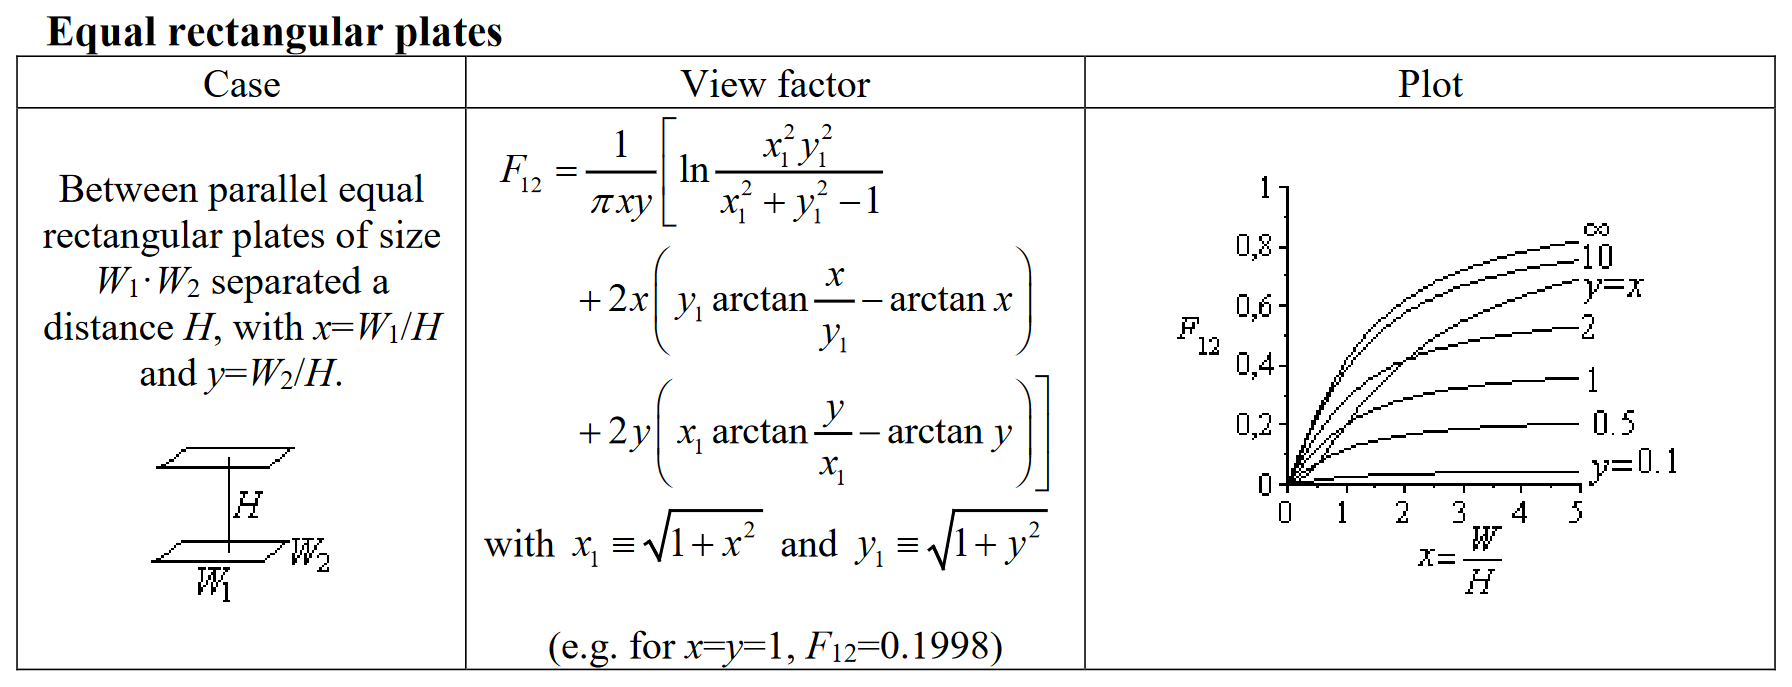
  For a single block, \$ W_1 = W_2 = 8.04 , x = y ~= x_1 = y_1 = 61.8 , F_A = 0.969 $
  
  + An "infinite bounce" emissivity for structure should be \$ \epsilon_\infty = 1 - \sum_{n = 0}^{\infty}(1-\epsilon_0)^{n+1}(F_A)^{n}(1 - F_A)$
  
  + \$ \epsilon_\infty = 0.998371 $ for a single block
+ **Air Convection**
  + Minimized by the aluminum walls and extended supports
  + Low speed air flow
+ **Cloud Cover**
  + No cloud cover
+ **Water Vapor Supply**
  + Always replenished immediately within the system
+ **Environment**
  + Slow changing dew point and humidity
    + *TODO: Implement [Clausius-Clapeyron](https://www.theweatherprediction.com/habyhints/186/) equation to accept air temperature and relative humidity to find dew point*
      
      \$ \ln \left( \frac{E_s}{6.11} \right) = \left( \frac{L}{R_v} \right) \left( \frac{1}{273} - \frac{1}{T} \right) $
      
      + \$ E_s $ is the saturation vapor pressure at the given temperature.
      
      + \$ L $ is the latent heat of vaporization, 2.453e6 J/kg.
      
      + \$ R_v $ is the gas constant for moist air, 461 J/kg.
      
      + \$ T $ is the air temperature.
    + Plug air temperature into equation to find saturation water vapor pressure:
      
      \$ E_s = 6.11 * \exp \left( \left( \frac{L}{R_v} \right) \left( \frac{1}{273} - \frac{1}{T_{air}} \right) \right) $
      
    + Multiply saturation vapor pressure by relative humidity to find current vapor pressure
    + Plug vapor pressure into equation to find dew point temperature:
      
      \$ T_{dp} = \left( \frac{1}{273} - \left( \frac{R_v}{L} \right) \ln \left( \frac{E_{dp}}{6.11} \right) \right)^{-1} $
  + Constant enthalpy of vaporization

<a name="setup"></a>
## Setup

<a name="python-imports"></a>
### Python Imports

In [1]:
import bokeh.plotting
import bokeh.io
import datetime
import numpy as np


bokeh.io.output_notebook()

Loading BokehJS ...

<a name="panel-calculations"></a>
### Panel Calculations

In [2]:
#### Inputs
H    = 1.9                 # Spacing between plates, inches
W    = 8.04                 # Edge length of square plate, inches
D    = 0.08                 # Panel thickness, inches
#L   = 8.625                # Total length for panels, inches
L    = 8.625                # Total length for panels, inches

#### Calculations
x    = W / H
y    = x
x1   = (1 + x**2)**(0.5)
y1   = x1

F = (1/(np.pi*x*y)) * (np.log((x1**2 * y1**2)/(x1**2 + y1**2 - 1)) + 2*x*(y1*np.arctan(x/y1) - np.arctan(x)) + 2*y*(x1*np.arctan(y/x1) - np.arctan(y)))
print('F = %.4f' % (F))

#N = (8.625 - 0.25 - D) / (D + H)
N = (L - 0.25 - D) / (D + H)
print('N = %.4f' % (N))

F = 0.6474
N = 4.1894


<a name="constant-definitions"></a>
### Constant Definitions

In [3]:
#### Physical Constants
s    = 5.6703e-8            # Stefan-Boltzmann constant, Watts per (meter^2 * Kelvin^4)
C    = 0.91                 # Aluminum specific heat capacity, Joules per (gram * Kelvin)
Hvap = 2503                 # Enthalpy of vaporization for water at 0C, Joules per gram
                            # Convert to linear value based on dew point?
                            #   100 C: 40.657
                            #     0 C: 45.051
                            #   -33 C: 46.567

#### Design Constants
#eta  = 0.998                                   # Emissivity of condenser panels
eta  = 0.95                                     # Emissivity of condenser panels
m    = 2.7*np.floor(N)*.063*(8.04**2)*(2.54**3) # Radiator mass for one block, grams
Ap   = 2*np.floor(N)*(8.04**2)*(.0254**2)       # Total area exposed to air for one block, meters
Ac   = (1 - F) * Ap                             # Condenser area exposed for radiation for one block, meters

#### Environment Constants
h    = 0.1                  # Convective heat transfer coefficient
Ts   = 4                    # Night sky/outer space temperature, Kelvin

<a name="model-inputs"></a>
### Model Inputs

In [4]:
#### Transient Model Inputs
#Tm  = 8*60*60              # Transient modeling time, seconds
Tm   = 1*10*60              # Transient modeling time, seconds

#### Environment Inputs
TA   = 290                  # Air temperature, Kelvin
T_dp = 273                  # Dew point, Kelvin

#### Design Inputs
T_0  = TA+1                 # Initial condenser temperature, Kelvin
bNum = 3                    # Number of blocks to simulate with

##### Time, air temp, dew point arrays
KLAX21_02_18 = [            # LA Shoreline, 2021-02-18
    [datetime.datetime.strptime('2021-02-18 19:53', '%Y-%m-%d %H:%M'), 13+273.15,  8+273.15],
    [datetime.datetime.strptime('2021-02-18 20:53', '%Y-%m-%d %H:%M'), 13+273.15,  7+273.15],
    [datetime.datetime.strptime('2021-02-18 21:53', '%Y-%m-%d %H:%M'), 12+273.15,  6+273.15],
    [datetime.datetime.strptime('2021-02-18 22:53', '%Y-%m-%d %H:%M'), 13+273.15,  6+273.15],
    [datetime.datetime.strptime('2021-02-18 23:53', '%Y-%m-%d %H:%M'), 11+273.15,  5+273.15],
    [datetime.datetime.strptime('2021-02-19 00:53', '%Y-%m-%d %H:%M'), 10+273.15,  4+273.15],
    [datetime.datetime.strptime('2021-02-19 01:53', '%Y-%m-%d %H:%M'), 11+273.15,  3+273.15],
    [datetime.datetime.strptime('2021-02-19 02:53', '%Y-%m-%d %H:%M'),  9+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-19 03:53', '%Y-%m-%d %H:%M'),  8+273.15,  0+273.15]
]

KLAX21_02_20 = [            # LA Shoreline, 2021-02-20
    [datetime.datetime.strptime('2021-02-20 19:53', '%Y-%m-%d %H:%M'), 13+273.15,  8+273.15],
    [datetime.datetime.strptime('2021-02-20 20:53', '%Y-%m-%d %H:%M'), 13+273.15,  8+273.15],
    [datetime.datetime.strptime('2021-02-20 21:53', '%Y-%m-%d %H:%M'), 13+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-20 22:53', '%Y-%m-%d %H:%M'), 13+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-20 23:53', '%Y-%m-%d %H:%M'), 11+273.15,  8+273.15],
    [datetime.datetime.strptime('2021-02-21 00:53', '%Y-%m-%d %H:%M'), 11+273.15,  8+273.15],
    [datetime.datetime.strptime('2021-02-21 01:53', '%Y-%m-%d %H:%M'), 10+273.15,  7+273.15],
    [datetime.datetime.strptime('2021-02-21 02:53', '%Y-%m-%d %H:%M'),  9+273.15,  7+273.15],
    [datetime.datetime.strptime('2021-02-21 03:53', '%Y-%m-%d %H:%M'),  9+273.15,  7+273.15]
]

KLAX21_02_23 = [            # LA Shoreline, 2021-02-23
    [datetime.datetime.strptime('2021-02-23 19:53', '%Y-%m-%d %H:%M'), 15+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-23 20:53', '%Y-%m-%d %H:%M'), 15+273.15, 11+273.15],
    [datetime.datetime.strptime('2021-02-23 21:53', '%Y-%m-%d %H:%M'), 16+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-23 22:53', '%Y-%m-%d %H:%M'), 15+273.15,  8+273.15],
    [datetime.datetime.strptime('2021-02-23 23:53', '%Y-%m-%d %H:%M'), 14+273.15, 10+273.15],
    [datetime.datetime.strptime('2021-02-24 00:53', '%Y-%m-%d %H:%M'), 12+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-24 01:47', '%Y-%m-%d %H:%M'), 12+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-24 01:53', '%Y-%m-%d %H:%M'), 12+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-24 02:53', '%Y-%m-%d %H:%M'), 11+273.15,  9+273.15],
    [datetime.datetime.strptime('2021-02-24 03:53', '%Y-%m-%d %H:%M'), 11+273.15,  9+273.15]
]

KLAX21_02_24 = [            # LA Shoreline, 2021-02-24
    [datetime.datetime.strptime('2021-02-24 19:53', '%Y-%m-%d %H:%M'), 11+273.15,  10+273.15],
    [datetime.datetime.strptime('2021-02-24 20:14', '%Y-%m-%d %H:%M'), 11+273.15,   9+273.15],
    [datetime.datetime.strptime('2021-02-24 20:53', '%Y-%m-%d %H:%M'), 12+273.15,  10+273.15],
    [datetime.datetime.strptime('2021-02-24 21:53', '%Y-%m-%d %H:%M'), 12+273.15,   9+273.15],
    [datetime.datetime.strptime('2021-02-24 22:51', '%Y-%m-%d %H:%M'), 12+273.15,  11+273.15],
    [datetime.datetime.strptime('2021-02-24 23:53', '%Y-%m-%d %H:%M'), 12+273.15,  11+273.15],
    [datetime.datetime.strptime('2021-02-25 00:11', '%Y-%m-%d %H:%M'), 12+273.15,  11+273.15],
    [datetime.datetime.strptime('2021-02-25 00:53', '%Y-%m-%d %H:%M'), 12+273.15,  11+273.15],
    [datetime.datetime.strptime('2021-02-25 01:53', '%Y-%m-%d %H:%M'), 11+273.15,  10+273.15],
    [datetime.datetime.strptime('2021-02-25 02:53', '%Y-%m-%d %H:%M'), 11+273.15,  10+273.15],
    [datetime.datetime.strptime('2021-02-25 03:53', '%Y-%m-%d %H:%M'), 11+273.15,   9+273.15]
]

KSBD21_02_16 = [            # LA Desert, 2021-02-16
    [datetime.datetime.strptime('2021-02-16 19:53', '%Y-%m-%d %H:%M'), 14+273.15,  4+273.15],
    [datetime.datetime.strptime('2021-02-16 20:56', '%Y-%m-%d %H:%M'), 12+273.15,  3+273.15],
    [datetime.datetime.strptime('2021-02-16 21:40', '%Y-%m-%d %H:%M'), 12+273.15,  3+273.15],
    [datetime.datetime.strptime('2021-02-16 22:00', '%Y-%m-%d %H:%M'), 11+273.15,  3+273.15],
    [datetime.datetime.strptime('2021-02-16 22:20', '%Y-%m-%d %H:%M'), 10+273.15,  4+273.15],
    [datetime.datetime.strptime('2021-02-16 22:40', '%Y-%m-%d %H:%M'), 10+273.15,  4+273.15],
    [datetime.datetime.strptime('2021-02-16 23:00', '%Y-%m-%d %H:%M'),  9+273.15,  3+273.15],
    [datetime.datetime.strptime('2021-02-16 23:20', '%Y-%m-%d %H:%M'),  8+273.15,  2+273.15],
    [datetime.datetime.strptime('2021-02-16 23:40', '%Y-%m-%d %H:%M'),  8+273.15,  1+273.15],
    [datetime.datetime.strptime('2021-02-17 00:00', '%Y-%m-%d %H:%M'),  6+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-17 00:20', '%Y-%m-%d %H:%M'),  7+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-17 00:40', '%Y-%m-%d %H:%M'),  7+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-17 01:00', '%Y-%m-%d %H:%M'),  6+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-17 01:20', '%Y-%m-%d %H:%M'),  7+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-17 01:40', '%Y-%m-%d %H:%M'),  8+273.15,  2+273.15],
    [datetime.datetime.strptime('2021-02-17 02:00', '%Y-%m-%d %H:%M'),  7+273.15,  2+273.15],
    [datetime.datetime.strptime('2021-02-17 02:20', '%Y-%m-%d %H:%M'),  6+273.15,  1+273.15],
    [datetime.datetime.strptime('2021-02-17 02:40', '%Y-%m-%d %H:%M'),  6+273.15,  0+273.15],
    [datetime.datetime.strptime('2021-02-17 03:00', '%Y-%m-%d %H:%M'),  6+273.15,  1+273.15],
    [datetime.datetime.strptime('2021-02-17 03:20', '%Y-%m-%d %H:%M'),  6+273.15,  2+273.15],
    [datetime.datetime.strptime('2021-02-17 03:40', '%Y-%m-%d %H:%M'),  8+273.15,  4+273.15],
    [datetime.datetime.strptime('2021-02-17 04:00', '%Y-%m-%d %H:%M'),  8+273.15,  4+273.15]
]

KPAS22_04_16 = [            # LA Shoreline, 2021-02-24
    [datetime.datetime.strptime('2022-04-16 20:00', '%Y-%m-%d %H:%M'), 16+273.15,   9+273.15],
    [datetime.datetime.strptime('2022-04-16 21:00', '%Y-%m-%d %H:%M'), 15+273.15,  10+273.15],
    [datetime.datetime.strptime('2022-04-16 22:00', '%Y-%m-%d %H:%M'), 14+273.15,  10+273.15],
    [datetime.datetime.strptime('2022-04-16 23:00', '%Y-%m-%d %H:%M'), 13+273.15,  10+273.15],
    [datetime.datetime.strptime('2022-04-17 00:00', '%Y-%m-%d %H:%M'), 13+273.15,  10+273.15],
    [datetime.datetime.strptime('2022-04-17 01:00', '%Y-%m-%d %H:%M'), 13+273.15,  10+273.15],
    [datetime.datetime.strptime('2022-04-17 02:00', '%Y-%m-%d %H:%M'), 13+273.15,  10+273.15],
    [datetime.datetime.strptime('2022-04-17 03:00', '%Y-%m-%d %H:%M'), 13+273.15,   9+273.15],
    [datetime.datetime.strptime('2022-04-17 04:00', '%Y-%m-%d %H:%M'), 12+273.15,   9+273.15],
    [datetime.datetime.strptime('2022-04-17 05:00', '%Y-%m-%d %H:%M'), 12+273.15,   9+273.15],
    [datetime.datetime.strptime('2022-04-17 06:00', '%Y-%m-%d %H:%M'), 12+273.15,   9+273.15]
]

<a name="calculations"></a>
## Calculations

In [5]:
#### Transient Analysis
time   = np.arange(0, Tm, .1) # Discrete time-step array, deciseconds
rts    = []                   # Empty array for polynomial roots

##### Polynomial Coefficients
a_t    = (eta * s * bNum * Ac * time) / (bNum * m * C)
b_t    = (h * bNum * Ap * time) / (bNum * m * C)

##### Polynomial Analysis
for i in range(len(time)):
    #print('Computing roots for time #' + str(i))
    pol  = np.polynomial.polynomial.Polynomial(((-1*b_t[i]*TA - T_0 - a_t[i] * Ts**4), (1 + b_t[i]), 0, 0, a_t[i]))
    rts.append(pol.roots())

#### Steady-State Analysis

##### Temperature Polynomial Coefficients
a_ss   = eta * s * bNum * Ac
b_ss   = h * bNum * Ap
c_ss   = -1*(a_ss * Ts**4 + b_ss * TA)

##### Temperature Polynomial Analysis
pol_ss = np.polynomial.polynomial.Polynomial((c_ss, b_ss, 0, 0, a_ss))
rts_ss = pol_ss.roots()

##### Water Production Calculation
a_wp   = eta * s * bNum * Ac / Hvap
b_wp   = h * bNum * Ap / Hvap
c_wp   = -1*(a_ss * Ts**4 + b_ss * TA) / Hvap
m_dot  = a_wp * T_dp**4 + b_wp * T_dp + c_wp

###### Nightime Predicted Calculations

####### LA Shoreline, 2021-02-18
for x in KLAX21_02_18:
    c_wp   = -1*(a_ss * Ts**4 + b_ss * x[1])/ Hvap
    x.append(a_wp * x[2]**4 + b_wp * x[2] + c_wp)

####### LA Shoreline, 2021-02-20
for x in KLAX21_02_20:
    c_wp   = -1*(a_ss * Ts**4 + b_ss * x[1])/ Hvap
    x.append(a_wp * x[2]**4 + b_wp * x[2] + c_wp)

####### LA Shoreline, 2021-02-23
for x in KLAX21_02_23:
    c_wp   = -1*(a_ss * Ts**4 + b_ss * x[1])/ Hvap
    x.append(a_wp * x[2]**4 + b_wp * x[2] + c_wp)

####### LA Shoreline, 2021-02-24
for x in KLAX21_02_24:
    c_wp   = -1*(a_ss * Ts**4 + b_ss * x[1])/ Hvap
    x.append(a_wp * x[2]**4 + b_wp * x[2] + c_wp)

####### LA Desert, 2021-02-16
for x in KSBD21_02_16:
    c_wp   = -1*(a_ss * Ts**4 + b_ss * x[1])/ Hvap
    x.append(a_wp * x[2]**4 + b_wp * x[2] + c_wp)

####### JPL Parking Lot, 2022-04-16
for x in KPAS22_04_16:
    c_wp   = -1*(a_ss * Ts**4 + b_ss * x[1])/ Hvap
    x.append(a_wp * x[2]**4 + b_wp * x[2] + c_wp)



#### Radiation Panel Calculation

##### Constants
m_dot  = 1

A      = eta * s * (T_dp**4 - Ts**4)
B      = h * (TA - T_dp)
C      = m_dot * Hvap

##### Minimum Value
y      = 0
x0     = (B * y + C) / A

print('For %.1f sq. meters of convection area, %.4f sq. meters of radiation area is needed for %.4f grams per second of water condensation.\n' % (y, x0, m_dot))
print('Every sq. meter of additional convective area requires an additional %.4f sq. meters of radiative area to compensate.\n\n' % (B/A))

##### Straight addition of area
y      = x0 + 5
x      = (B * y + C) / A

print('For %.1f sq. meters of convection area, %.4f sq. meters of radiation area is needed for %.4f grams per second of water condensation.\n\n' % (y, x, m_dot))

##### Fancy area based on view factor from above?
#y      = 2*120*((8.04)**2)*(.0254**2)
#x      = (B * y + C) / A
y       = (A * (x0 / (1 - F)) - C) / B

print('For a view factor of %.4f between panels, %.1f sq. meters of convective area is required for %.4f grams per second of water condensation.\n\n' % (F, y, m_dot))
#print('For %.4f sq. meters of convection area, %.4f sq. meters of radiation area is needed for %.4f grams per second of water condensation.' % (y, x, m_dot))

##### Find the water rate for a known condenser area with equal convective and radiative areas
x       = 1
m_dot   = (A - B) * x / Hvap

print('For an area of %.2f sq. meters, %.4f grams of water will be produced each second.' % (x, m_dot))

For 0.0 sq. meters of convection area, 8.3653 sq. meters of radiation area is needed for 1.0000 grams per second of water condensation.

Every sq. meter of additional convective area requires an additional 0.0057 sq. meters of radiative area to compensate.


For 13.4 sq. meters of convection area, 8.4412 sq. meters of radiation area is needed for 1.0000 grams per second of water condensation.


For a view factor of 0.6474 between panels, 2703.0 sq. meters of convective area is required for 1.0000 grams per second of water condensation.


For an area of 1.00 sq. meters, 0.1189 grams of water will be produced each second.


<a name="results"></a>
## Results

<a name="transient-temperature-timeline"></a>
### Transient Temperature Timeline

In [6]:
#### Results array setup
y = []

#### Selecting the correct roots
y.append(rts[0][0])                                       # The first root is the starting temperature for the system
for i in range(len(rts) - 1):                             # Check each subsequent solution to the polynomial
    for j in range(len(rts[i+1])):                        # Which has 6 total roots
        if( np.isreal(rts[i+1][j]) ):                     # Select out only the real roots
            if( abs(rts[i+1][j] - y[i]) < 1):             # Check for the nearest root to the past root
                y.append(rts[i+1][j].real)                # Append the real component to the result array

y_s = [x - T_dp for x in y]                               # Subtract the dew point from every result 
try:
    idx = np.argwhere(np.diff(np.sign(y_s))).flatten()[0] # Identify the index where dew point is reached
except IndexError:
    print('Dew Point is not reached in time!')
    idx = -1
except:
    print('Error!')

#### Make a graph
p = bokeh.plotting.figure(title="Predicted Transient Temperature Response for Water Condensation System", toolbar_location="right")

p.xaxis.axis_label = 'Time (s)'
p.yaxis.axis_label = 'Temperature (K)'

p.line(time, y, legend_label="System Temperature (K)", line_color="blue", line_width=2)
p.line([time[0], time[-1]],[T_dp, T_dp], legend_label="Dew Point (K)", line_dash=[6, 6], line_color="black", line_width=4)
p.circle(time[idx], y[idx], radius=2, legend_label='%.1f seconds' % (time[idx]), color="red")

bokeh.plotting.show(p)

<a name="steady-state-temperature"></a>
### Steady-State Temperature

In [7]:
print('\nSteady-State Temperature without water condensation:\n')
for x in rts_ss:
    if( np.isreal(x) ):
        if( x > 0 ):
            print('%.1f Kelvin\n' % (x.real))
print(rts_ss)


Steady-State Temperature without water condensation:

161.3 Kelvin

[-228.58176076  +0.j           33.62708428-200.67109277j
   33.62708428+200.67109277j  161.3275922   +0.j        ]


<a name="steady-state-water-production"></a>
### Steady-State Water Production

In [8]:
print('\nSteady-State water production if dew point of ' + str(T_dp) + ' K can be reached:')
print(str(round(m_dot, 4)) + ' g/s of water produced!\n')

print('Assuming 6 hours of Steady-State production time per night, you need ' + str(round(20000/(m_dot*6*60*60), 2)) + ' devices to make 20 liters of water per night.')

#### Make location graphs

##### LA Shoreline, 2021-02-18
a = bokeh.plotting.figure(title="Predicted Water Production at KLAX, 2021-02-18", toolbar_location="right", x_axis_type="datetime")

a.xaxis.axis_label = 'Time of day'
a.yaxis.axis_label = 'Water production (g/s)'

t = []
md = []
for x in KLAX21_02_18:
    t.append(x[0])
    #print(x[-1])
    md.append(x[-1])

w = 0
for i in range(len(t)-1):
    w += 0.5*(md[i+1] + md[i])*((t[i+1] - t[i]).seconds)   

a.line(t, md, legend_label='%.1f grams' % (w), line_color="blue", line_width=2)

bokeh.plotting.show(a)

##### LA Shoreline, 2021-02-20
b = bokeh.plotting.figure(title="Predicted Water Production at KLAX, 2021-02-20", toolbar_location="right", x_axis_type="datetime")

b.xaxis.axis_label = 'Time of day'
b.yaxis.axis_label = 'Water production (g/s)'

t = []
md = []
for x in KLAX21_02_20:
    t.append(x[0])
    md.append(x[-1])

w = 0
for i in range(len(t)-1):
    w += 0.5*(md[i+1] + md[i])*((t[i+1] - t[i]).seconds)

b.line(t, md, legend_label='%.1f grams' % (w), line_color="blue", line_width=2)

bokeh.plotting.show(b)

##### LA Shoreline, 2021-02-23
c = bokeh.plotting.figure(title="Predicted Water Production at KLAX, 2021-02-23", toolbar_location="right", x_axis_type="datetime")

c.xaxis.axis_label = 'Time of day'
c.yaxis.axis_label = 'Water production (g/s)'

t = []
md = []
for x in KLAX21_02_23:
    t.append(x[0])
    md.append(x[-1])

w = 0
for i in range(len(t)-1):
    w += 0.5*(md[i+1] + md[i])*((t[i+1] - t[i]).seconds)

c.line(t, md, legend_label='%.1f grams' % (w), line_color="blue", line_width=2)

bokeh.plotting.show(c)

##### LA Shoreline, 2021-02-24
d = bokeh.plotting.figure(title="Predicted Water Production at KLAX, 2021-02-24", toolbar_location="right", x_axis_type="datetime")

d.xaxis.axis_label = 'Time of day'
d.yaxis.axis_label = 'Water production (g/s)'

t = []
md = []
for x in KLAX21_02_24:
    t.append(x[0])
    md.append(x[-1])

w = 0
for i in range(len(t)-1):
    w += 0.5*(md[i+1] + md[i])*((t[i+1] - t[i]).seconds)

d.line(t, md, legend_label='%.1f grams' % (w), line_color="blue", line_width=2)

bokeh.plotting.show(d)

##### LA Deser, 2021-02-16
e = bokeh.plotting.figure(title="Predicted Water Production at KSBD, 2021-02-16", toolbar_location="right", x_axis_type="datetime")

e.xaxis.axis_label = 'Time of day'
e.yaxis.axis_label = 'Water production (g/s)'

t = []
md = []
for x in KSBD21_02_16:
    t.append(x[0])
    md.append(x[-1])

w = 0
for i in range(len(t)-1):
    w += 0.5*(md[i+1] + md[i])*((t[i+1] - t[i]).seconds)

e.line(t, md, legend_label='%.1f grams' % (w), line_color="blue", line_width=2)

bokeh.plotting.show(e)

##### JPL Parking Lot, 2022-04-16
e = bokeh.plotting.figure(title="Predicted Water Production at JPL Parking Lot, 2022-04-16", toolbar_location="right", x_axis_type="datetime")

e.xaxis.axis_label = 'Time of day'
e.yaxis.axis_label = 'Water production (g/s)'

t = []
md = []
for x in KPAS22_04_16:
    t.append(x[0])
    md.append(x[-1])

w = 0
for i in range(len(t)-1):
    w += 0.5*(md[i+1] + md[i])*((t[i+1] - t[i]).seconds)

e.line(t, md, legend_label='%.1f grams' % (w), line_color="blue", line_width=2)

bokeh.plotting.show(e)


Steady-State water production if dew point of 273 K can be reached:
0.1189 g/s of water produced!

Assuming 6 hours of Steady-State production time per night, you need 7.79 devices to make 20 liters of water per night.
